# **Assignment : Dimensionality Reduction using T-SNE on Amazon Fine Foods Review Dataset**

# Objective :

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

Id
ProductId - unique identifier for the product
UserId - unqiue identifier for the user
ProfileName
HelpfulnessNumerator - number of users who found the review helpful
HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
Score - rating between 1 and 5
Time - timestamp for the review
Summary - brief summary of the review
Text - text of the review


Objective - To use t-SNE on the output of word vectorization techniques

In [3]:
# Importing the required packages
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import gensim
import re
import string
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

**The dataset is in the form of an .sqlite file. Using pandas package to read the file and then extract reviews which are either greater than 3 or less than 3. Reviews aith Score 3 are neutral and as such is ambiguous**

In [4]:
con = sqlite3.connect('AmazonReviews.sqlite')
review_dataset = pd.read_sql_query("""select * from reviews where score != '3'""",con)

In [5]:
def partition(data):
    if (data < 3):
        return 'negative'
    else:
        return 'positive'

    
review_score = review_dataset['Score']
positiveNegative = review_score.map(partition)
review_dataset['Score'] = positiveNegative

In [6]:
print(review_dataset.shape)
review_dataset.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Data Preprocessing

The dataset contains duplicate rows. It also contains rows where the helpfulness numerator is lager than the helpfulness denominator 


In [7]:
sorted_data=review_dataset.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)


#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(review_dataset['Id'].size*1.0)*100


(364173, 10)


69.25890143662969

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)



(364171, 10)


In [7]:
final = final.sort_values('Score', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_positive = final.iloc[-5000:,]
final_negative = final.iloc[:5000:,]
print(final_positive.shape)
print(final_negative.shape)

(5000, 10)
(5000, 10)


In [8]:
final = final_positive.append(final_negative,ignore_index= True)
final = final.sample(frac=1).reset_index(drop=True)

In [9]:
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

negative    5000
positive    5000
Name: Score, dtype: int64

# Preparation for Text Vectorization

Before converting the text to vectors,few operations have to be performed.
1. Removal of HTML Codes
2. Removal of Special Characters
3. Removal of Stop Words


In [10]:
#nltk.download('stopwords')
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

In [11]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [12]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [13]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [14]:
'''final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)'''

"final.head(3) #below the processed review can be seen in the CleanedText Column \n\n\n# store final table into an SQlLite table for future.\nconn = sqlite3.connect('final.sqlite')\nc=conn.cursor()\nconn.text_factory = str\nfinal.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)"

# Vectorization - Bag of Words

A bag-of-words model, or BoW for short, is a way of extracting features from text.It describes the occurrence of words within a document. It involves two things:
1. A vocabulary of known words.
2. A measure of the presence of known words.
It is called a “bag” of words, because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not where in the document.

In [15]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 12782)
the number of unique words  12782


In [16]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'food', 2674), (b'like', 2152), (b'love', 2014), (b'tea', 1918), (b'dog', 1782), (b'good', 1775), (b'tast', 1669), (b'great', 1605), (b'product', 1575), (b'one', 1487), (b'use', 1397), (b'flavor', 1341), (b'tri', 1293), (b'get', 1180), (b'cat', 1092), (b'eat', 1072), (b'make', 1067), (b'bag', 972), (b'would', 933), (b'time', 932)]
Most Common Negative Words :  [(b'tast', 3134), (b'like', 3008), (b'product', 2451), (b'flavor', 1960), (b'one', 1734), (b'tri', 1716), (b'would', 1560), (b'tea', 1495), (b'good', 1375), (b'food', 1322), (b'coffe', 1254), (b'use', 1207), (b'get', 1207), (b'buy', 1180), (b'order', 1138), (b'box', 1125), (b'dont', 1036), (b'eat', 1001), (b'even', 993), (b'amazon', 942)]


In [17]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (10000, 238945)
the number of unique words including both unigrams and bigrams  238945


In [18]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(final_counts)
print(standardized_data.shape)
#standardized_data.toarray()


(10000, 12782)


In [19]:

#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 100,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)

(10000, 100)


In [20]:
def tsne(data,components,perplexity,iterations):
    tic = time.time()
    model = TSNE(n_components= components,random_state=0,perplexity= perplexity,n_iter= iterations)
    tsne_data = model.fit_transform(data)
    toc = time.time()
    #print("TSNE Function executed in: ",toc - tic,' seconds')
    return tsne_data

In [21]:
'''  Function to plot TSNE Model
     Arguments - 
     1. Data - Data on which TSNE will run
     2. Labels - Class Labels
     3. Perplexity = No of Datapoints whose distances should be preserved
     4. Iterations - No of times to iterate to reach optimal output
 
 '''

def plotTSNE(data,labels,perplexity,iterations):
    tsne_df = pd.DataFrame(tsne_data,columns = ('Dim1','Dim2','Label'))
    #plt.title('With perplexity = ',perplexity)
    sns.FacetGrid(tsne_df,hue = ('Label'),height = 6).map(plt.scatter,'Dim1','Dim2').add_legend()
    plt.plot()

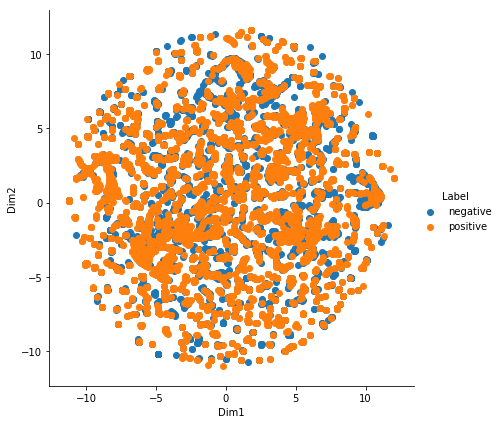

TSNE with perplexity =  2 and iterations = 1000


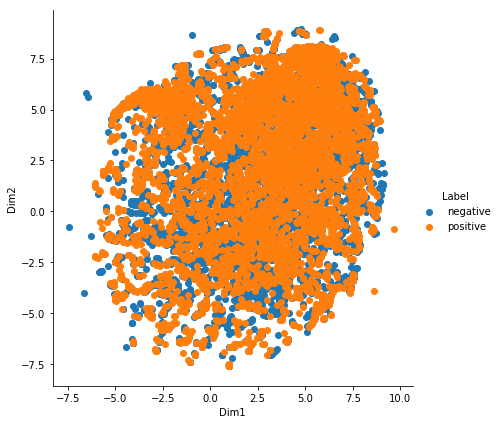

TSNE with perplexity =  20 and iterations = 1000


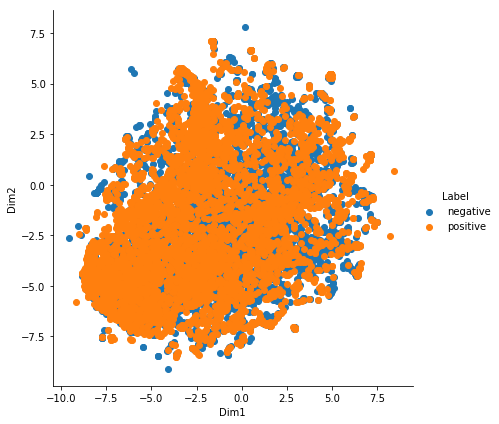

TSNE with perplexity =  30 and iterations = 1000


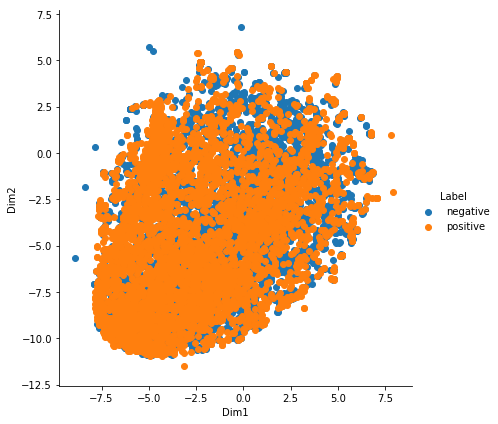

TSNE with perplexity =  50 and iterations = 1000


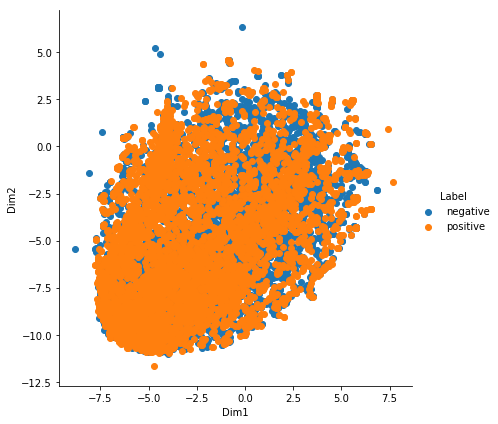

TSNE with perplexity =  80 and iterations = 1000


In [22]:
test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

The above T-SNE plots represents how the dimentionality of BoW featurization was reduced from 12782 dimensions to 2 dimensions.
The perplexity was in the range of 2,20,30,50 and 80 with 1000 iterations.

Please note : T-SNE uses only dense matrix representation. Since BoW gives a sparse matrix as output, we have to use TruncatedSVD to reduce its dimensions and get a dense matrix output. This can then be fed to T-SNE for further dimensionaliy reduction. Since, the dimensions of BoW output is very large, .toarray() and .todense() throws memory error.

# Vectorization  -  TF-IDF 

TF-IDF stands for “Term Frequenct — Inverse Data Frequency”.


Term Frequency (tf): gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases.

Inverse Data Frequency (idf): used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score.

In [23]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (10000, 238945)
the number of unique words including both unigrams and bigrams  238945


In [24]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(final_tf_idf)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]

(10000, 238945)


In [25]:

#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 100,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)

(10000, 100)


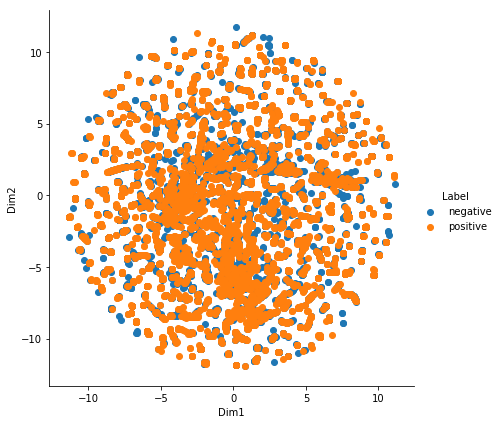

TSNE with perplexity =  2 and iterations = 1000


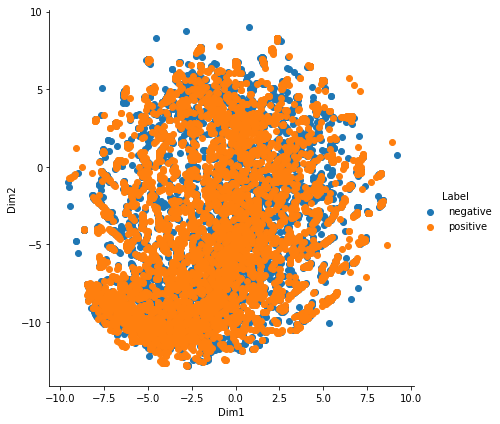

TSNE with perplexity =  20 and iterations = 1000


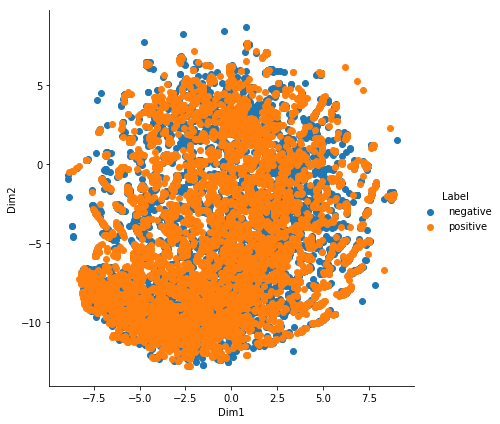

TSNE with perplexity =  30 and iterations = 1000


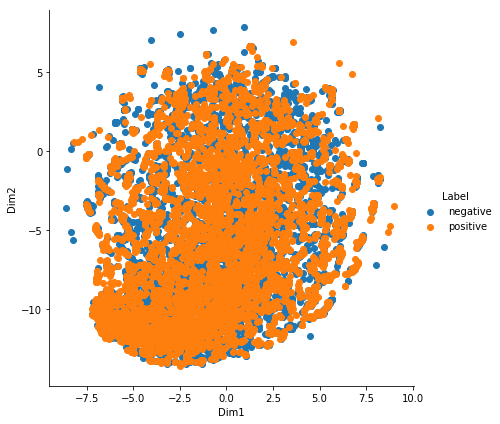

TSNE with perplexity =  50 and iterations = 1000


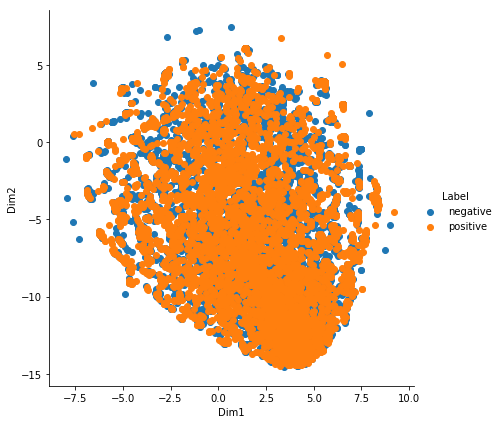

TSNE with perplexity =  80 and iterations = 1000


In [26]:
test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity = [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

The above T-SNE plots represents how the dimentionality of TF-IDF featurization was reduced from 238945 dimensions to 2 dimensions.
The perplexity was in the range of 2,20,30,50 and 80 with 1000 iterations.

Please note : T-SNE uses only dense matrix representation. Since TF-IDF gives a sparse matrix as output, we have to use TruncatedSVD to reduce its dimensions and get a dense matrix output. This can then be fed to T-SNE for further dimensionaliy reduction. Since, the dimensions of TF-IDF output is very large, .toarray() and .todense() throws memory error.

# Vectorization - Word2Vec

The idea behind Word2Vec is pretty simple. We’re making an assumption that the meaning of a word can be inferred by the company it keeps. This is analogous to the saying, “show me your friends, and I’ll tell who you are”. If you have two words that have very similar neighbors (meaning: the context in which its used is about the same), then these words are probably quite similar in meaning or are at least related. For example, the words shocked, appalled and astonished are usually used in a similar context.
Using this underlying assumption, you can use Word2Vec to surface similar concepts, find unrelated concepts, compute similarity between two words and more.

In [27]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [28]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [29]:
w2v_words = list(w2v_model.wv.vocab)

### Average Word2Vec

In [30]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

10000
50


(10000, 50)


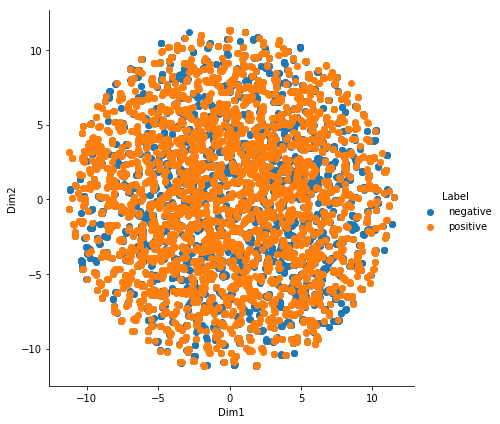

TSNE with perplexity =  2 and iterations = 1000


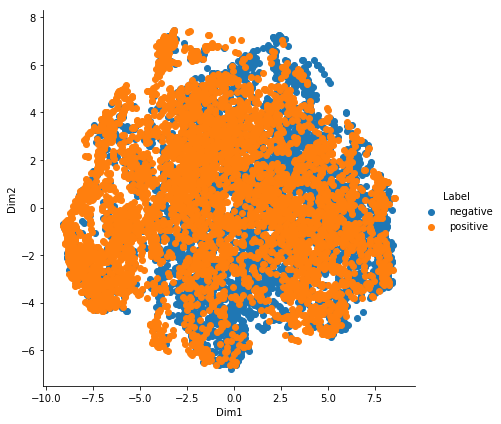

TSNE with perplexity =  20 and iterations = 1000


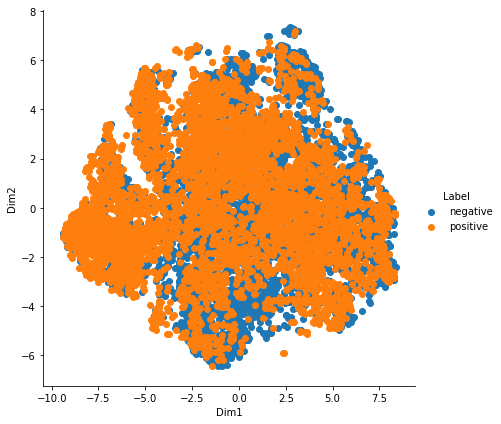

TSNE with perplexity =  30 and iterations = 1000


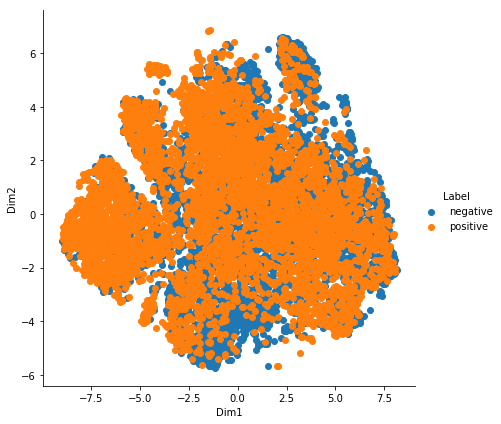

TSNE with perplexity =  50 and iterations = 1000


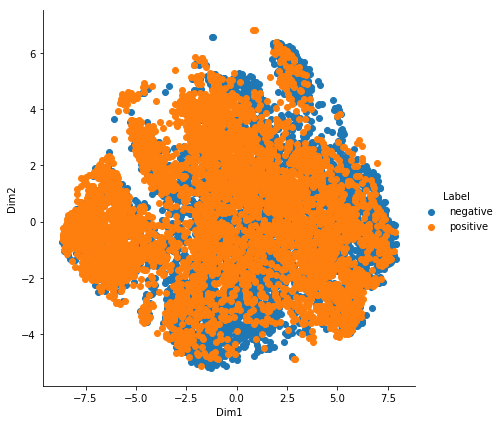

TSNE with perplexity =  80 and iterations = 1000


In [31]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(sent_vectors)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]


'''#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 100,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)'''


test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity =  [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

The above T-SNE plots represents how the dimentionality of Average Word2Vec featurization was reduced from 50 dimensions to 2 dimensions.
The perplexity was in the range of 2,20,30,50 and 80 with 1000 iterations.

Since, average Word2Vec gives a dense matrix as output, we can directly use T-SNE on the vectorized output.

### TF-IDF Weighted Word2Vec

In [32]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

10000
50


(10000, 50)


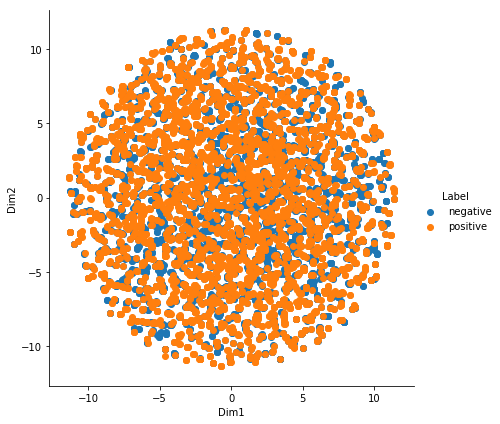

TSNE with perplexity =  2 and iterations = 1000


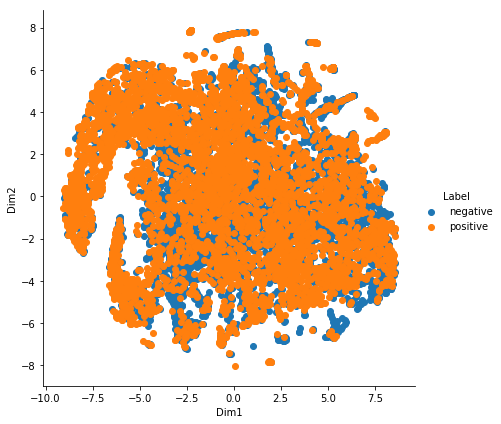

TSNE with perplexity =  20 and iterations = 1000


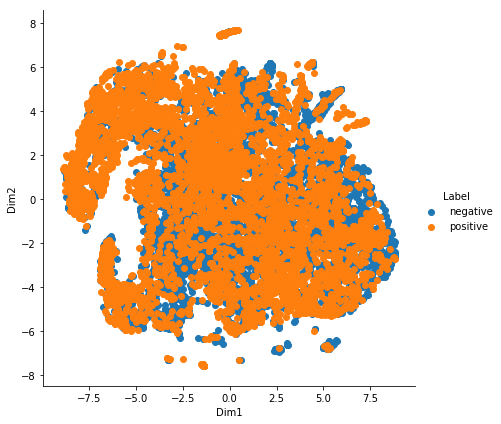

TSNE with perplexity =  30 and iterations = 1000


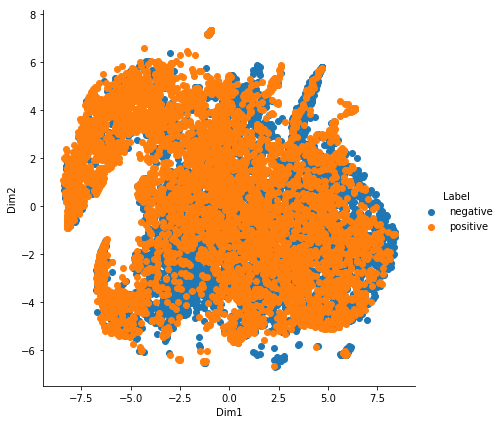

TSNE with perplexity =  50 and iterations = 1000


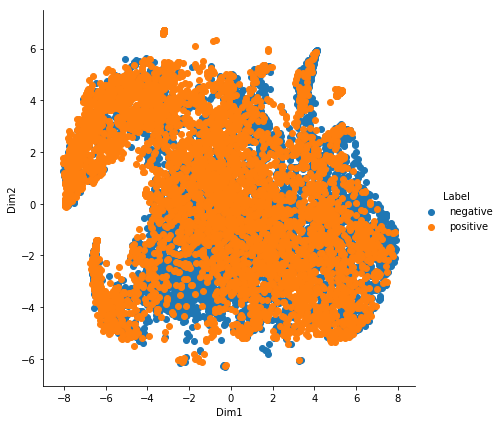

TSNE with perplexity =  80 and iterations = 1000


In [34]:
# Standardize Data
standardized_data = StandardScaler( with_mean=False).fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)
#standardized_data.toarray()
#standardized_data = standardized_data[:100,]


'''#standardized_data = standardized_data[:10000,]
#standardized_data = standardized_data.todense()
truncated = TruncatedSVD(n_components= 100,random_state= 0)
standardized_data = truncated.fit_transform(standardized_data)
print(standardized_data.shape)'''


test_data= standardized_data
test_label = final['Score']
#test_label = test_label[:100,]



perplexity =  [2,20,30,50,80]


for i in perplexity:
    send_perplexity = i
    tsne_data = tsne(test_data,components=2,perplexity= i,iterations=1000)
    tsne_data = np.vstack((tsne_data.T, test_label)).T
    plotTSNE(data = tsne_data,labels = test_label,perplexity= send_perplexity,iterations=1000)
    plt.show()
    print('TSNE with perplexity = ',i,'and iterations = 1000') 

The above T-SNE plots represents how the dimentionality of TF-IDF weighted Word2Vec featurization was reduced from 50 dimensions to 2 dimensions.
The perplexity was in the range of 2,20,30,50 and 80 with 1000 iterations.

Since, TF-IDF weighted Word2Vec gives a dense matrix as output, we can directly use T-SNE on the vectorized output.